# Code for running the 3D incompressible SG solver

First load in the required packages and sub folders

In [1]:
import initialconditions as ic
import matplotlib.pyplot as plt
import numpy as np

import main as main
import sys
sys.path.append("/home/s2250115/petsc/arch-linux-c-debug/lib")

import animators as ani

Next define the system parameters, the initial condition, and visualise the initial condition

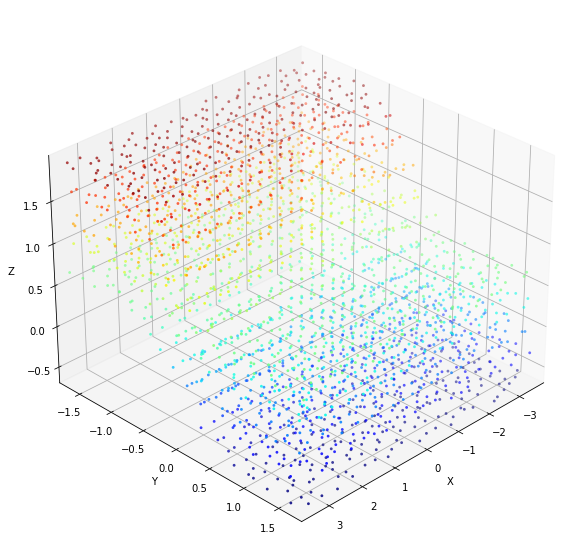

In [2]:
# Define the parameters of the system

box = [-3.66, -1.75, 0, 3.66, 1.75, 0.45] # List or tuple defining domain [xmin, ymin, zmin, xmax, ymax, zmax]
per_tol = 1e-3 # Percent tolerance
per_x = True # Set the periodicity of X
per_y = False # Set the periodicity of Y
per_z = False # Set the periodicity of Z
tf = 5 # Final time
Ndt = 200 # Number of timesteps

# Define the parameters and initialize an artifical initial condition

#N = 1000
#Z = ic.create_artificial_initial(N, box[0] + 0.1, box[1] + 0.1, box[2] + 0.1, box[3] - 0.1, box[4] - 0.1, box[5] - 0.1, 'lattice', 0.85) #Create an artificial initial condition that is a lattice with a sine perturbation

# Define the parameters and initialize an initial condition that is a perturbation of a steady background state

# N = 1000
# B = np.array([[6, 2, 3], [2, 6, 5], [3, 5, 6]]) #Create background steady state
# Z = ic.create_ss_initial(N, B, box, 'Thermal Sine') #Initial seed positions as a perturbation of a steady state

# Define the parameters and initialize an initial condition that is an isolated cyclone

NumCol = 529 # Number of columns used
NumRow = 5 # Number of points in each column between the max and min temperature
N = NumCol * NumRow # Total number of seeds
A = 0 # Shear parameter can either be 0 or 0.1
Z = ic.create_cyc_initial(NumCol, NumRow, box, A, per_x, per_y, per_z) #Initial seed positions for an isolated cyclone with no shear, shear can be set to 0.1

# Plot the initial condition

fig = plt.figure()
fig.set_size_inches(10, 10, True)
ax = fig.add_subplot(projection='3d')
ax.scatter(Z[:,0], Z[:,1], Z[:,2], c = Z[:,2], cmap = 'jet', edgecolor = 'none', s = 8) #Points colored based on their 3rd component i.e. temperature
ax.set_xlim([np.min(Z[:,0]), np.max(Z[:,0])])
ax.set_ylim([np.min(Z[:,1]), np.max(Z[:,1])])
ax.set_zlim([np.min(Z[:,2]), np.max(Z[:,2])])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev = 30, azim = 45) #Viewing angle on the inital conditions

plt.show()

Next run the code

In [3]:
main.SG_solver(box, Z, N, per_tol, tf, Ndt, per_x, per_y, per_z, debug = True) #Solve and save the solution 

#Can activate the optional variables solver, and debug to control which linear solver the code uses and whether or not the code is in debug mode.

Time Step 0
Total: 11.52899999999998
Difference in target and final mass 5.7684962505699784e-08
Time Step 1
Total: 11.529000000000025
Difference in target and final mass 5.996670929562657e-08
2
Total: 11.52900000000001
Difference in target and final mass 6.339335581870578e-08
3
Total: 11.529
Difference in target and final mass 6.788468563533828e-08
4
Total: 11.528999999999998
Difference in target and final mass 7.34345735050795e-08
5
Total: 11.52899999999999
Difference in target and final mass 7.867462477100222e-08
6
Total: 11.528999999999986
Difference in target and final mass 8.393270183989337e-08
7
Total: 11.528999999999996
Difference in target and final mass 8.937013794573582e-08
8
Total: 11.529000000000018
Difference in target and final mass 9.467868158077021e-08
9
Total: 11.529000000000005
Difference in target and final mass 9.988775256561094e-08
10
Total: 11.52900000000001
Difference in target and final mass 1.050831005155447e-07
11
Total: 11.528999999999987
Difference in target

Next animate the solutions

In [ ]:
from pysdot.domain_types import ConvexPolyhedraAssembly
from pysdot import PowerDiagram
import pyvista as pv
import imageio.v2 as iio
import csv
csv.field_size_limit(min(sys.maxsize, 2147483646))

# Animate the particles 

#ani.point_animator('./data/SG_data.csv', 'C', '2D', box, tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
#ani.point_animator('./data/SG_data.csv', 'C', '3D', box, tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
#ani.point_animator('./data/SG_data.csv', 'Z', '2D', box, tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'
#ani.point_animator('./data/SG_data.csv', 'Z', '3D', box, tf) #Animate the seeds or centroids depending on choice of 'Z' or 'C' and '2D' or '3D'

#Animate the cells

coloring = 'ZVel' # Chose how to colour the cells can be temperature ('Temp'), meridonal velocity ('Vel'), 

# Construct the domain
domain = ConvexPolyhedraAssembly()
domain.add_box([box[0], box[1], box[2]], [box[3], box[4], box[5]])

# Initialize lists to store the loaded data
seeds = []
centroids = []
weights = []

# Load the data from the CSV file
with open('./data/SG_data.csv', mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        seeds.append(eval(row['Seeds']))
        centroids.append(eval(row['Centroids']))
        weights.append(eval(row['Weights']))

# Access the individual arrays
Z = np.array(seeds)
C = np.array(centroids)
W = np.array(weights)

# Compute the coloring
if coloring == 'MVel':
    #Compute Meridonal Velocities
    f = 1e-4
    MVel = [[0] * len(W[0]) for _ in range(len(W))]
    for i in range(len(W)):
        for j in range(len(W[0])):
            MVel[i][j] = f * (Z[i][j][0] - C[i][j][0])
elif coloring == 'ZVel':
    #Compute Zonal Velocities
    f = 1e-4
    ZVel = [[0] * len(W[0]) for _ in range(len(W))]
    for i in range(len(W)):
        for j in range(len(W[0])):
            ZVel[i][j] = f * ( - Z[i][j][1] + C[i][j][1])
elif coloring == 'Temp':
    # Compute the temperatures
    f = 1e-4
    g = 9.81
    th0 = 303.15
    T = [[0] * len(W[0]) for _ in range(len(W))]
    for i in range(len(W)):
        for j in range(len(W[0])):
            T[i][j] = 14 * Z[i][j][2] + th0
else:
    raise ValueError('Please specify how you want to colour the cells')

# Set up the animation parameters
n_frames = len(W)  # Number of frames

# Create an empty list to store frames
frames = []

# Generate frames for the animation
for i in range(n_frames):

    #Draw the tessellation
    pd = PowerDiagram(positions = Z[i] , weights = W[i] , domain = domain)

    # Store the volumes in an array
    if coloring == 'MVel':
        vols = np.array(MVel[i])
    elif coloring == 'ZVel':
        vols = np.array(ZVel[i])
    elif coloring == 'Temp':
        vols = np.array(T[i])
    else:
        raise ValueError('Please specify how you want to colour the cells')

    # Save the results in a .vtk file
    filename = "./data/results.vtk"
    pd.display_vtk(filename)

    # Read the data
    grid=pv.read(filename)

    # create cell data that gives the cell volumes, this allows us to colour by cell volumes
    cell_vols = vols[grid.cell_data['num'].astype(int)]
    grid.cell_data['vols']=cell_vols

    # plot the data with an automatically created plotter, for a static picture use backend='static'
    plotter = pv.Plotter(window_size=[800,800], notebook = False, off_screen=True)
    plotter.add_mesh(grid)

    # Render the frame
    plotter.show()

    # Add a headlight
    light=pv.Light(light_type='headlight')
    plotter.add_light(light)

    # Get the frame as an image array
    frame = plotter.screenshot(transparent_background=True)

    # Add the frame to the list of frames
    frames.append(frame)

# Save the frames as an animation file
output_file = './animations/SG_Cells.gif'
iio.mimwrite(output_file, frames, format='gif', duration = 1000 / 40)